In [1]:
import numpy as np
import pandas as pd
import csv
#import torch
from math import factorial
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def pos(i,prod):
    '''
    Compute positive function and gradient information
    
    input:
        i - index of function
        t - iteration
        prod - wt*xt
        
    output:
        fpt - positive function value
        gfpt - positive function gradient
    '''
    fpt = 0.0 
    gfpt = 0.0 
    fpt = (L/2+prod)**i 
    gfpt = i*(L/2+prod)**(i-1) # no xt yet!
    return fpt,gfpt               

In [3]:
def comb(n, k):
    '''
    Compute combination
    
    input:
        n - total number
        k - number of chosen
    
    output:
        c - number of combination
    '''
    return factorial(n) / factorial(k) / factorial(n - k)

In [4]:
def neg(loss,i,prod):
    '''
    Compute negative function and gradient information
    
    input:
        loss - loss function
        i - index of function
        t - iteration
        prod - wt*xt
        
    output:
        fnt - negative function value
        gfnt - negative function gradient
    '''
    fnt = 0.0 # n stands for negative
    gfnt = 0.0
    for k in range(i,N+1):
        # compute forward difference
        delta = 0.0
        for j in range(k+1):
            delta += (-1)**(k-j)*comb(k,j)*loss(j/N)
        # compute coefficient
        beta = comb(N,k)*comb(k,i)*(N+1)*delta/(2*L)**k
        # compute function value
        fnt += beta*(L/2-prod)**(k-i)
        # compute gradient
        gfnt += beta*(k-i)*(L/2-prod)**(k-i-1)  # no xt yet!
    return fnt,gfnt

In [5]:
def w_grad(gfpt,gfnt,yt,at,bt,alphat):
    '''
    Gradient with respect to w
    
    input:
        fpt - positive function at t
        gfpt - positive function gradient at t
        fnt - negative function at t
        gfnt - negative function gradient at t
        yt - sample label at t
        pt - p at t
        at - a at t
        bt - b at t
        alphat - alpha at t
    output:
        gradwt - gradient w.r.t. w at t
    '''
    gradwt = 0.0
    if yt == 1:
        gradwt = 2*(alphat - at)*gfpt
    else:
        gradwt = 2*(alphat - bt)*gfnt
    return gradwt

In [6]:
def proj(wt,R):
    '''
    Projection
    
    input:
        wt - w at t
        R - radius
        
    output:
        proj - projected wt
    '''
    norm = np.linalg.norm(wt)
    if norm > R:
        wt = wt/norm*R
    return wt

In [7]:
def a_grad(fpt,yt,at):
    '''
    Gradient with respect to a
    
    input:
        fpt - positive function at t
        yt - sample label at t
        pt - p at t
        at - a at t
    
    output:
        gradat - gradient w.r.t a at t
    '''
    gradat = 0.0 
    if yt == 1:
        gradat = 2*(at - fpt)
    else:
        gradat = 2*at
    return gradat

In [8]:
def b_grad(fnt,yt,bt):
    '''
    Gradient with respect to b
    
    input:
        fnt - negative function at t
        yt - sample label at t
        pt - p at t
        bt - b at t
    
    output:
        gradbt - gradient w.r.t b at t
    '''
    gradbt = 0.0 
    if yt == 1:
        gradbt = 2*bt
    else:
        gradbt = 2*(bt - fnt)
    return gradbt

In [9]:
def alpha_grad(fpt,fnt,yt,alphat):
    '''
    Gradient with respect to alpha
    '''
    gradalphat = 0.0
    if yt == 1:
        gradalphat = -2*(alphat - fpt)
    else:
        gradalphat = -2*(alphat - fnt)
    return gradalphat

In [131]:
def loader(filename):
    '''
    Data file loader
    
    input:
        filename - filename
    
    output:
        x - sample features
        y - sample labels
    '''
    # raw data
    L = []
    with open(filename,'r') as file:
        for line in csv.reader(file, delimiter = ' '):
            line[0] = '0:'+line[0]
            line.remove('')
            L.append(dict(i.split(':') for i in line))
    df = pd.DataFrame(L,dtype=float).fillna(0)
    X = df.iloc[:,1:].values
    Y = df.iloc[:,0].values
    # centralize
    mean = np.mean(X,axis=1)
    #X = (X.transpose() - mean).transpose()
    # normalize
    norm = np.linalg.norm(X,axis=1)
    #X = X/norm[:,None]
    # convert to binary class
    r = np.ptp(Y)
    index = np.argwhere(Y<r//2)
    INDEX = np.argwhere(Y>=r//2)
    Y[index] = -1
    Y[INDEX] = 1
    return X,Y

In [117]:
def prox(eta,loss,wj,aj,bj,alphaj,bwt,bat,bbt,balphat,x,y):
    '''
    perform proximal guided gradient descent when receive an sample
    '''
    prod = np.inner(wj,x)
    fpt = np.zeros(N+1)
    gfpt = np.zeros(N+1)
    fnt = np.zeros(N+1)
    gfnt = np.zeros(N+1)
    aJ = np.zeros(N+1)
    bJ = np.zeros(N+1)
    alphaJ = np.zeros(N+1)
    gradwt = 0.0
    gradat = 0.0
    gradbt = 0.0
    fval = 0.0
    for i in range(N+1):
        fpt[i],gfpt[i] = pos(i,prod)
        fnt[i],gfnt[i] = neg(loss,i,prod)
        gradwt += w_grad(gfpt[i],gfnt[i],y,aj[i],bj[i],alphaj[i]) # accumulate i
        gradat = a_grad(fpt[i],y,aj[i])
        gradbt = b_grad(fnt[i],y,bj[i])
        gradalphat = alpha_grad(fpt[i],fnt[i],y,alphaj[i])
        aJ[i] = aj[i] - eta*(gradat/(N+1)+gamma*(aj[i]-bat[i]))
        bJ[i] = bj[i] - eta*(gradbt/(N+1)+gamma*(bj[i]-bbt[i]))
        #alphaJ[i] = aJ[i] + bJ[i]
        alphaJ[i] = alphaj[i] + eta*gradalphat/(N+1)
    wJ = wj - eta*(gradwt*x*y/(N+1) + l*wj + gamma*(wj - bwt))
    wJ = proj(wJ,np.sqrt(1/l))
    #aJ = proj(aJ,1)
    #bJ = proj(bJ,1)
    #alphaJ = proj(alphaJ,1)
    
    return wJ,aJ,bJ,alphaJ

In [118]:
def PGSPD(t,loss,X,Y,bwt,bat,bbt,balphat):
    '''
    Proximally Guided Stochastic Primal Dual Algorithm
    '''
    
    # initialize inner loop variables
    Wt = bwt+0.0
    At = bat+0.0
    Bt = bbt+0.0
    ALPHAt = balphat+0.0
    
    BWt = Wt+0.0
    BAt = At+0.0
    BBt = Bt+0.0
    BALPHAt = ALPHAt+0.0
    
    ETAt = 1/np.sqrt(t)/M # M is the bound for gradient
    # inner loop update at j
    for j in range(1,t+1): 
        # update inner loop variables
        Wt,At,Bt,ALPHAt = prox(ETAt,loss,Wt,At,Bt,ALPHAt,bwt,bat,bbt,balphat,X[j-1],Y[j-1])
        BWt += Wt
        BAt += At
        BBt += Bt
        BALPHAt += ALPHAt
        
    # update outer loop variables
    bwt = BWt/t
    bat = BAt/t
    bbt = BBt/t
    balphat = BALPHAt/t
    
    return bwt,bat,bbt,balphat

In [133]:
def SOLAM(t,batch,X,Y,loss,wt,at,bt,alphat):
    '''
    Stochastic Online AUC Maximization step
    
    input:
        T - total number of iteration
        F - objective function value
        loss - loss function
        pt - p at t
        wt - w at t
        at - a at t
        bt - b at t
        alphat - alpha at t
    output:
        W - record of each wt
        A - record of each at
        B - record of each bt
        ALPHA - record of each alphat
    '''
    # Loop in the batch
    peta = 1/t/2
    deta = np.sqrt(np.log(T)/T)
    for k in range(batch):
        
        # Update wt,at,bt
        prod = np.dot(wt,X[k])
        fpt = np.zeros(N+1)
        gfpt = np.zeros(N+1)
        fnt = np.zeros(N+1)
        gfnt = np.zeros(N+1)
        gradwt = 0.0
        gradat = 0.0
        gradbt = 0.0
        gradalphat = 0.0
        
        for i in range(N+1): # add up info of each i
            fpt[i],gfpt[i] = pos(i,prod) # partial info
            fnt[i],gfnt[i] = neg(loss,i,prod)
            gradwt += w_grad(gfpt[i],gfnt[i],Y[k],at[i],bt[i],alphat[i])
            gradat = a_grad(fpt[i],Y[k],at[i])
            gradbt = b_grad(fnt[i],Y[k],bt[i])
            gradalphat = alpha_grad(fpt[i],fnt[i],Y[k],alphat[i])
            at[i] -= deta*gradat/(N+1)/batch
            bt[i] -= deta*gradbt/(N+1)/batch
            alphat[i] += deta*gradalphat/(N+1)/batch
        
        wt = wt - peta*(gradwt*Y[k]*X[k]/(N+1)/batch + l*wt) # step size as 1/t gradient descent
        
    #wt = proj(wt,1/l)    
        
    return wt,at,bt,alphat

In [125]:
hinge = lambda x:max(0,1+L-2*L*x)
logistic = lambda x:np.log(1+np.exp(L-2*L*x))
square = lambda x:(1+L-2*L*x)**2

N = 20
L = 2
M = .1 # weak convexity parameter
gamma = 1

batch = 1

T = 200 
l = 1

In [126]:
def demo(dataset,loss,alg):
    '''
    Run it to get results
    '''
    FEATURES,LABELS = loader(dataset)
    X_train, X_test, Y_train, Y_test = train_test_split(FEATURES, LABELS, test_size=0.2, random_state=0)

    # get dimensions of the data
    n,d = X_train.shape
    
    # initialize outer loop variables
    WT = np.zeros(d) # d is the dimension of the features
    AT = np.zeros(N+1)
    BT = np.zeros(N+1)
    ALPHAT = np.zeros(N+1)

    roc_auc = np.zeros(T)
    for t in range(1,T+1):
        if alg == 'PGSPD':
            # sample a point
            index = np.random.randint(n, size=t)
            features = FEATURES[index,:]
            labels = LABELS[index]
            # update outer loop variables
            WT,AT,BT,ALPHAT = PGSPD(t,loss,features,labels,WT,AT,BT,ALPHAT)
        elif alg == 'SOLAM':
            start = (t*batch)%n
            end = ((t+1)*batch)%n
            if start < end:
                x_train = X_train[start:end]
                y_train = Y_train[start:end]
            else: # need to think better
                x_train = np.append(X_train[start:],X_train[:end],axis=0)
                y_train = np.append(Y_train[start:],Y_train[:end],axis=0)
            WT,AT,BT,ALPHAT = SOLAM(t,batch,x_train,y_train,loss,WT,AT,BT,ALPHAT)
        fpr, tpr, _ = roc_curve(Y_test, np.dot(X_test,WT))
        roc_auc[t-1] = auc(fpr, tpr)
        if t%100 == 0:
            print('iteration: %d AUC: %f' %(t,roc_auc[t-1]))
    
    return roc_auc

iteration: 100 AUC: 0.853052
iteration: 200 AUC: 0.839531
iteration: 300 AUC: 0.845496
iteration: 400 AUC: 0.846689
iteration: 500 AUC: 0.840127
iteration: 600 AUC: 0.833764
iteration: 700 AUC: 0.841121
iteration: 800 AUC: 0.838536
iteration: 900 AUC: 0.845297
iteration: 1000 AUC: 0.843905


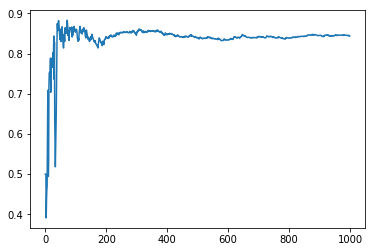

In [134]:
T = 1000
diabetes = demo('diabetes',hinge,'SOLAM')
plt.plot(diabetes)